In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

In [3]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [7]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skew is: 1.8828757597682129


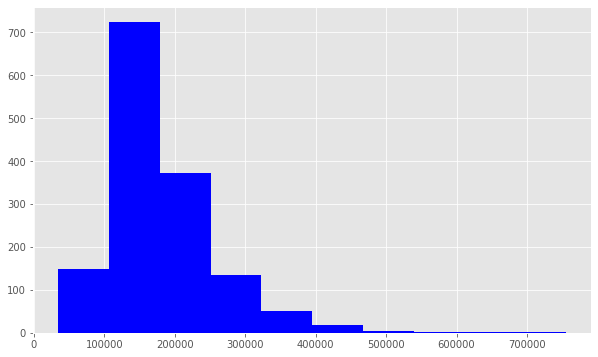

In [8]:
print ("Skew is:", train.SalePrice.skew())
plt.hist(train.SalePrice, color='blue')
plt.show() 

In [9]:
target = np.log(train.SalePrice)
target.skew()

0.12133506220520406

Skew is: 0.12133506220520406


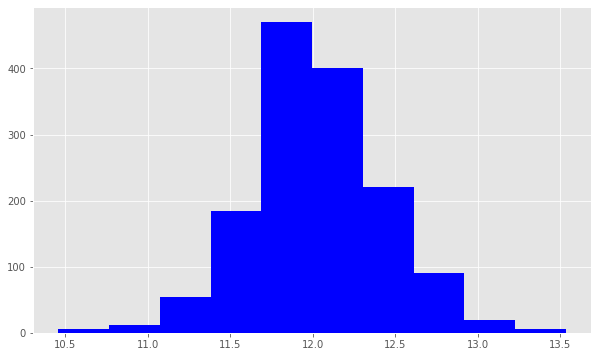

In [10]:
target = np.log(train.SalePrice)
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

In [11]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [12]:
corr = numeric_features.corr()
print (corr['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corr['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


In [13]:
train.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

In [14]:
quality_pivot = train.pivot_table(index='OverallQual',
                  values='SalePrice', aggfunc=np.median)
quality_pivot

,SalePrice
OverallQual,
1,50150
2,60000
3,86250
4,108000
5,133000
6,160000
7,200141
8,269750
9,345000


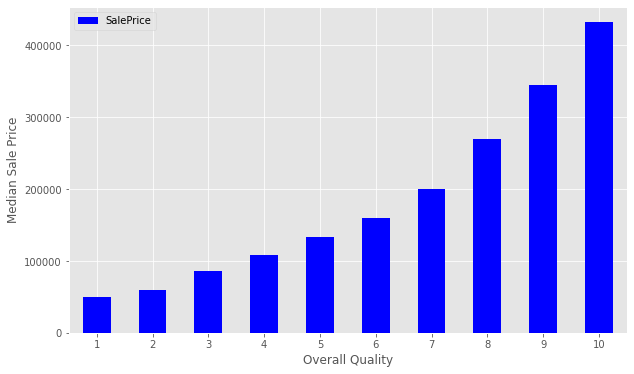

In [15]:
quality_pivot.plot(kind='bar', color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [16]:
train = train[train['GarageArea'] < 1200]

In [17]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
PoolQC,1449
MiscFeature,1402
Alley,1364
Fence,1174
FireplaceQu,689
LotFrontage,258
GarageYrBlt,81
GarageCond,81
GarageType,81


In [18]:
print ("Unique values are:", train.MiscFeature.unique())

Unique values are: [nan 'Shed' 'Gar2' 'Othr' 'TenC']


In [19]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1455,1455,91,1455,1455,1455,1455,1455,1455,1455,...,1374,1374,1374,1374,1455,6,281,53,1455,1455
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,1147,1450,50,921,1309,1454,1048,1378,225,1257,...,867,605,1306,1321,1335,2,157,48,1266,1196


In [20]:
print ("Original: \n")
print (train.Street.value_counts(), "\n")

Original: 

Pave    1450
Grvl       5
Name: Street, dtype: int64 



In [21]:
train['enc_street'] = pd.get_dummies(train.Street, drop_first=True)
test['enc_street'] = pd.get_dummies(train.Street, drop_first=True)

In [22]:
print ('Encoded: \n')
print (train.enc_street.value_counts())

Encoded: 

1    1450
0       5
Name: enc_street, dtype: int64


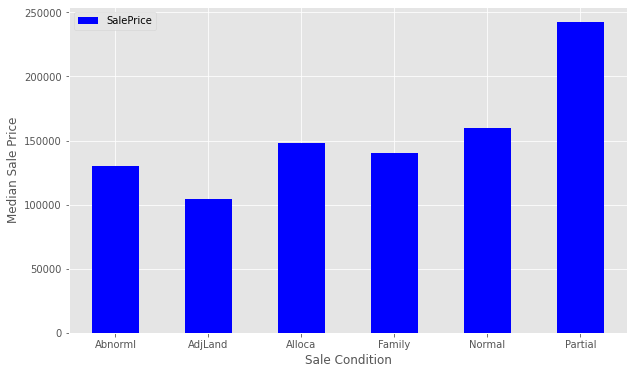

In [23]:
condition_pivot = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [24]:
def encode(x):
 return 1 if x == 'Partial' else 0
train['enc_condition'] = train.SaleCondition.apply(encode)
test['enc_condition'] = test.SaleCondition.apply(encode)

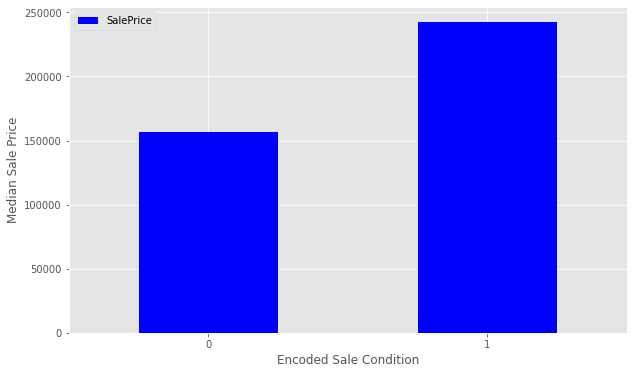

In [25]:
condition_pivot = train.pivot_table(index='enc_condition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [26]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()

In [27]:
sum(data.isnull().sum() != 0)

0

In [28]:
y = np.log(train.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis=1)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                          X, y, random_state=42, test_size=.33)

In [30]:
from sklearn import linear_model
lr = linear_model.LinearRegression()

In [31]:
model = lr.fit(X_train, y_train)

In [32]:
print ("R^2 is: \n", model.score(X_test, y_test))

R^2 is: 
 0.8882477709262545


In [33]:
predictions = model.predict(X_test)

In [34]:
from sklearn.metrics import mean_squared_error
print ('RMSE is: \n', mean_squared_error(y_test, predictions))

RMSE is: 
 0.017841794519567696


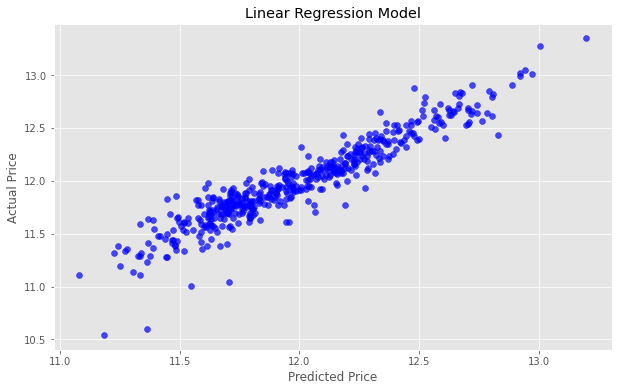

In [35]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

In [36]:
try1 = pd.DataFrame()
try1['Id'] = test.Id

In [37]:
feats = test.select_dtypes(
        include=[np.number]).drop(['Id'], axis=1).interpolate()

In [38]:
predictions = model.predict(feats)

In [39]:
final_predictions = np.exp(predictions)

In [40]:
print ("Original predictions are: \n", predictions[:5], "\n")
print ("Final predictions are: \n", final_predictions[:5])

Original predictions are: 
 [11.76725362 11.71929504 12.07656074 12.20632678 12.11217655] 

Final predictions are: 
 [128959.49172586 122920.74024359 175704.82598102 200050.83263756
 182075.46986405]


In [41]:
try1['SalePrice'] = final_predictions
try1.head()

,Id,SalePrice
0,1461,128959.491726
1,1462,122920.740244
2,1463,175704.825981
3,1464,200050.832638
4,1465,182075.469864


In [42]:
try1.to_csv('submission1.csv', index=False)